# 케라스

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




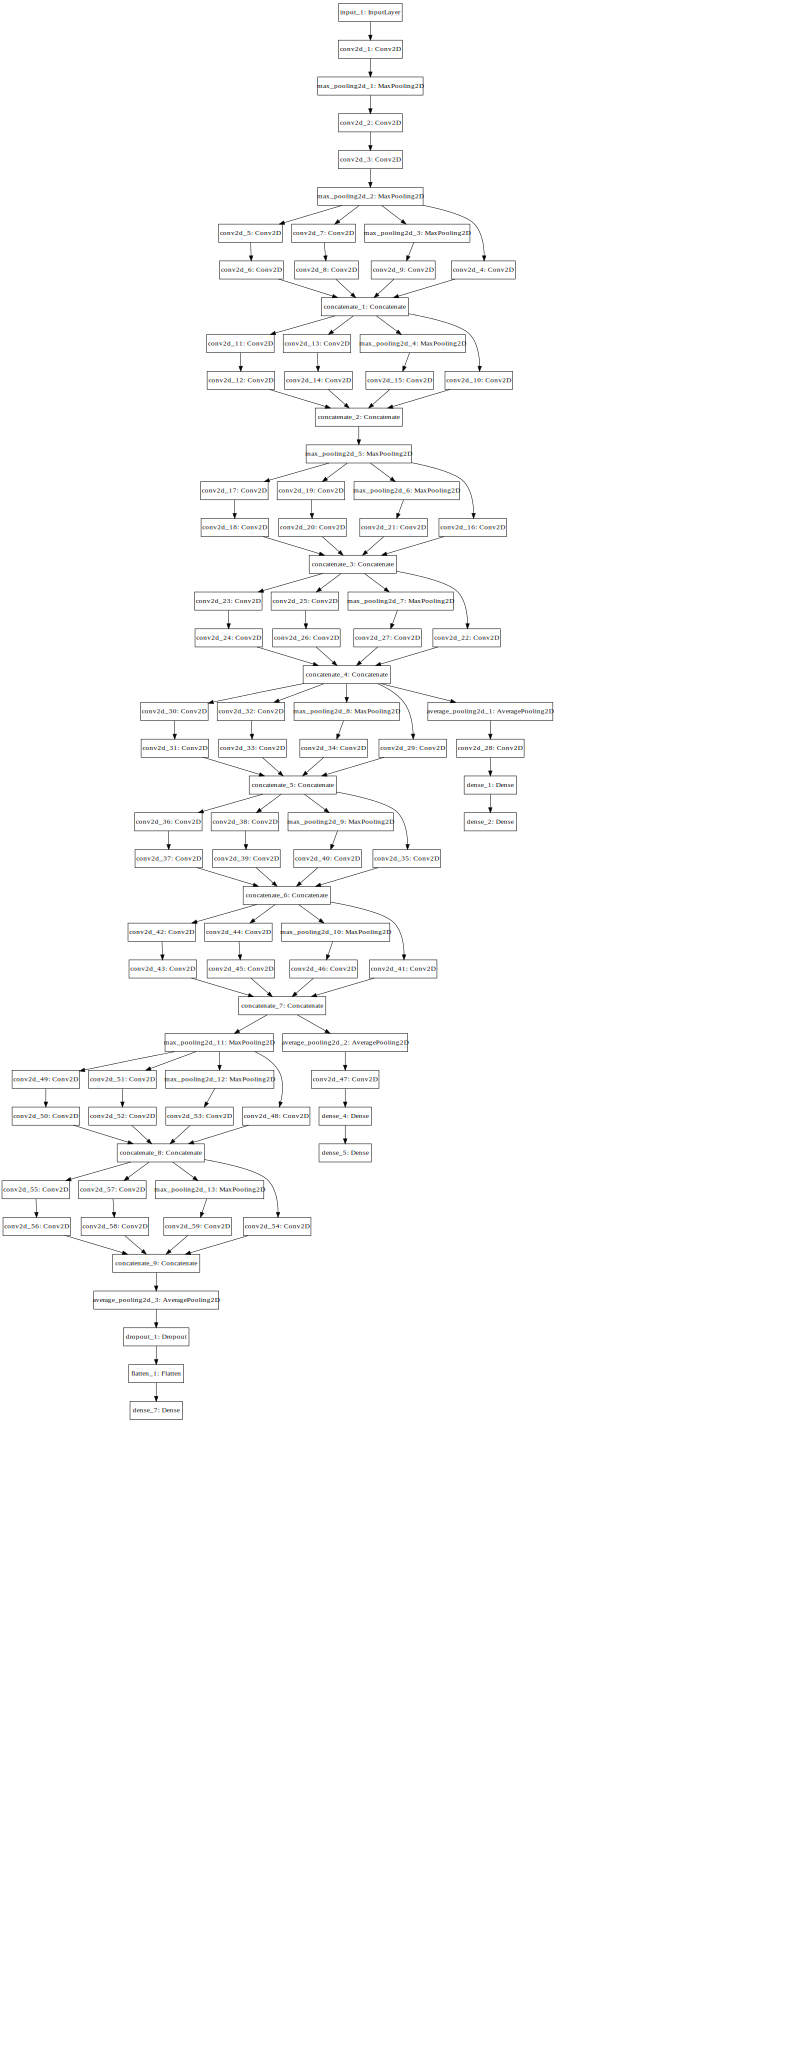

In [1]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, Dense, Dropout, AveragePooling2D, concatenate, Flatten
from keras.models import Model
from keras import models

def inception(x, c_1, c_2a, c_2b, c_3a, c_3b, c_m):
    
    pre_layer = x
    
    conv1 = Conv2D(filters = c_1, kernel_size = (1,1), strides = (1,1), padding = 'same', activation = 'relu')(pre_layer)
    
    conv2 = Conv2D(filters = c_2a, kernel_size = (1,1), strides = (1,1), padding = 'same', activation = 'relu')(pre_layer)
    conv2 = Conv2D(filters = c_2b, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu')(conv2)
    
    conv3 = Conv2D(filters = c_3a, kernel_size = (1,1), strides = (1,1), padding = 'same', activation = 'relu')(pre_layer)
    conv3 = Conv2D(filters = c_3b, kernel_size = (5,5), strides = (1,1), padding = 'same', activation = 'relu')(conv3)
    
    maxpool = MaxPooling2D(pool_size = (3,3), strides = (1,1), padding = 'same')(pre_layer)
    maxconv = Conv2D(filters = c_m, kernel_size = (1,1), strides = (1,1), padding = 'same', activation = 'relu')(maxpool)
    
    concat = concatenate([conv1, conv2, conv3, maxconv], axis = -1) # [B,W,H,C] 형태로 결과가 나오므로 채널인 'C' 기준으로 concat
    
    return concat

inputs = Input(shape=(224,224,3))

x = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2), padding = 'same', activation = 'relu')(inputs)
x = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

x = Conv2D(filters = 64, kernel_size = (1,1), strides = (1,1), padding = 'valid', activation = 'relu')(x)
x = Conv2D(filters = 192, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

x = inception(x, 64, 96, 128, 16, 32, 32) # 3a
x = inception(x, 128, 128, 192, 32, 96, 64) # 3b

x = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

x = inception(x, 192, 96, 208, 16, 48, 64) # 4a
x = inception(x, 160, 112, 224, 24, 64, 64) # 4b

aux0 = AveragePooling2D(pool_size = (5,5), strides = (3,3), padding = 'valid')(x)
aux0 = Conv2D(filters = 128, kernel_size = (1,1), strides = (3,3), padding = 'same')(aux0)
aux0 = Dense(1024, activation = 'relu')(aux0)
aux0 = Dense(1024, activation = 'relu')(aux0)
softmax0 = Dense(1000, activation = 'softmax')(aux0)

x = inception(x, 128, 128, 256, 24, 64, 64) # 4c
x = inception(x, 112, 144, 288, 32, 64, 64) # 4d
x = inception(x, 256, 160, 320, 32, 128, 128) # 4e

aux1 = AveragePooling2D(pool_size = (5,5), strides = (3,3), padding = 'valid')(x)
aux1 = Conv2D(filters = 128, kernel_size = (1,1), strides = (3,3), padding = 'same')(aux1)
aux1 = Dense(1024, activation = 'relu')(aux1)
aux1 = Dense(1024, activation = 'relu')(aux1)
softmax1 = Dense(1000, activation = 'softmax')(aux1)

x = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

x = inception(x, 256, 160, 320, 32, 128, 128) # 5a
x = inception(x, 384, 192, 384, 48, 128, 128) # 5b

x = AveragePooling2D(pool_size=(7,7), strides = (1,1), padding = 'valid')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

outputs = Dense(1000, activation = 'softmax')(x)

model = Model(inputs = inputs, outputs = [aux0, aux1, outputs])

model.compile(optimizer='adam', loss='categorical_crossentropy', loss_weights=[0.3,0.3,1.0]) 

from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model, dpi=50).create(prog='dot', format='svg'))

# 파이토치

In [ ]:
import torch
import torch.nn as nn
        
class Inception(nn.Module): # padding은 공식 이용해서 계산, stride는 주어짐, 'S'는 'same', 'V'는 'valid'로 간주
    
    def __init__(self, common_in_ch, o_c1, o_c2a, i_c2, o_c2b, o_c3a, i_c3, o_c3b, o_c4): 
        super(Inception, self).__init__()
        
        branch1 = []
        branch1 += [nn.Conv2d(in_channels = common_in_ch, out_channels = o_c1, kernel_size = 1, stride = 1, padding = 0),
                    nn.ReLU(True)]
        
        branch2 = []
        branch2 += [nn.Conv2d(in_channels = common_in_ch, out_channels = o_c2a, kernel_size = 1, stride = 1, padding = 0),
                    nn.ReLU(True),
                    nn.Conv2d(in_channels = i_c2, out_channels = o_c2b, kernel_size = 3, stride = 1, padding = 1),
                    nn.ReLU(True)]
        
        branch3 = []
        branch3 += [nn.Conv2d(in_channels = common_in_ch, out_channels = o_c3a, kernel_size = 1, stride = 1, padding = 0),
                    nn.ReLU(True),
                    nn.Conv2d(in_channels = i_c3, out_channels = o_c3b, kernel_size = 5, stride = 1, padding = 2),
                    nn.ReLU(True)]
        
        branch4 = []
        branch4 += [nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
                    nn.Conv2d(in_channels = common_in_ch, out_channels = o_c4, kernel_size = 1, padding = 0),
                    nn.ReLU(True)]
        
        self.layer1 = nn.Sequential(*branch1)
        self.layer2 = nn.Sequential(*branch2)
        self.layer3 = nn.Sequential(*branch3)
        self.layer4 = nn.Sequential(*branch4)
        
    def forward(self, x):
        
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x3 = self.layer3(x)
        x4 = self.layer4(x)
        
        out = torch.cat((x1, x2, x3, x4), dim = 1) # (batchsize, channel, width, height)
        
        return out

class GoogleNet(nn.Module):
    
    def __init__(self):
        super(GoogleNet, self).__init__()
        
        layer1 = []
        layer1 += [nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, stride = 2, padding = 3), 
                   nn.ReLU(True),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
                   nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 1, stride = 1, padding = 0), # (V)로 표시되서 valid로 간주
                   nn.ReLU(True),
                   nn.Conv2d(in_channels = 64, out_channels = 192, kernel_size = 3, stride = 1, padding = 1),
                   nn.ReLU(True),
                   Inception(192, 64, 96, 96, 128, 16, 16, 32, 32),
                   Inception(256, 128, 128, 128, 192, 32, 32, 96, 64),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
                   Inception(480, 192, 96, 96, 208, 16, 16, 48, 64),
                   Inception(512, 160, 112, 112, 224, 24, 24, 64, 64)]
        
        layer2 = []
        layer2 += [Inception(512, 128, 128, 128, 256, 24, 24, 64, 64),
                   Inception(512, 112, 144, 144, 288, 32, 32, 64, 64),
                   Inception(528, 256, 160, 160, 320, 32, 32, 128, 128)]
        
        layer3 = []
        layer3 += [nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
                   Inception(832, 256, 160, 160, 320, 32, 32, 128, 128),
                   Inception(832, 384, 192, 192, 384, 48, 48, 128, 128),
                   nn.AdaptiveAvgPool2d((7,7)),
                   nn.Dropout(0.4)]
        
        self.layer1 = nn.Sequential(*layer1)
        self.layer2 = nn.Sequential(*layer2)
        self.layer3 = nn.Sequential(*layer3)
        
        self.conv = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 1, stride = 1, padding = 1)
        
        self.dense1a = nn.Linear(in_features = 65664, out_features = 132096) # 이것들은 모두 keras의 summary를 통해서 알아냈음
        self.dense1b = nn.Linear(in_features = 106624, out_features = 132096)
        
        self.dense2 = nn.Linear(in_features = 132096, out_features = 1049600)
        
        self.dense3 = nn.Linear(in_features = 1024, out_features = 1000)
        
        self.avgpool = nn.AdaptiveAvgPool2d((5,5)) # AdaptiveAvgPool2d은 이 형태로만, stride와 padding 안들어감
        
    def forward(self, x):
        
        x = self.layer1(x)
        
        aux0 = self.avgpool(x)
        aux0 = self.conv(aux0)
        aux0 = self.dense1a(aux0)
        aux0 = self.dense2(aux0)
        
        x = self.layer2(x)
        
        aux1 = self.avgpool(x)
        aux1 = self.conv(aux1)
        aux1 = self.dense1b(aux1)
        aux1 = self.dense2(aux1)
        
        x = self.layer3(x)
        x = x.view(x.size(0),-1)
        x =  self.dense3(x)
        
        return x, aux0, aux1

if __name__ == '__main__':

    from torchsummary import summary
    model = GoogleNet()
    summary(model, (3, 224, 224))